<img src="../../docs/images/dlsia.png" width=600 />

# Supervised Image Denosing with MSDNets and SMSNet ensembles

**Authors**: Eric Roberts and Petrus Zwart

**E-mail:** PHZwart@lbl.gov, EJRoberts@lbl.gov

This notebook highlights some basic functionality with the dlsia package.

In this notebook we setup a Mixed-Scaled Dense Network (MSDNet) and train it to denoising image corrupted by Gaussian noise. Subsequently, we will train a number Randomized Sparse Networks (RMSNets) on the same task and show how to obtain error estimates via ensemble methods.

In [1]:
import sys
import os
import numpy as np
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

import h5py
from torchsummary import summary

/home/ejroberts/anaconda3/envs/dlsia/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dlsia.core import helpers
from dlsia.core.train_scripts import train_regression
from dlsia.core.networks import msdnet, smsnet, baggins
from dlsia.test_data.two_d import build_test_data, torch_hdf5_loader
from dlsia.viz_tools import plots, draw_sparse_network

import matplotlib.pyplot as plt

## Create Data

We produce noisy, single-class data consisting of peaks in guassian noise. This data will be generated using hdf5 files .

### Parameters to toggle:

- batch_size : number of images passed through GPU at a single time
- n_imgs : number of images in training set
- n_peaks : number of circular peaks in each image
- n_xy : size of images
- snr : signal-to-noise ratio; more noise for lower number

In [3]:
makeData = True     
batch_size = 100
num_workers = 0
showNoisyData = True
use_scaled_data = True

### Generate hdf5 peak data

In [4]:
if makeData == True:
    n_imgs = 200 
    n_peaks = 8
    n_xy = 32
    snr=3
    mask_radius = 1.0
    
    build_test_data.build_data_standard_sets_2d(n_imgs=n_imgs,
                                                n_peaks=n_peaks,
                                                n_xy=n_xy, 
                                                snr=snr,
                                                mask_radius=mask_radius)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 60.26it/s]


### Load hdf5 peak data

Data generator class above can generate the following:

- trax_GT : ground truth
- trax_obs : obstructed, noisy images
- trax_obs_norm : noisy images linearly scaled to interal [0,1]
- trax_mask : binary masked images indicating peak (1) or background (0)

In [5]:
if use_scaled_data == True:
    x_label = "trax_obs_norm"
else:
    x_label = "trax_obs"
    
f_train = "train_data_2d.hdf5"
f_test  = "test_data_2d.hdf5"
f_validation = "validate_data_2d.hdf5"

MyData_train = torch_hdf5_loader.Hdf5Dataset2D(filename=f_train, 
                                               x_label=x_label, 
                                               y_label="trax_GT")
MyData_validation = torch_hdf5_loader.Hdf5Dataset2D(filename=f_validation, 
                                                    x_label=x_label, 
                                                    y_label="trax_GT")
MyData_test = torch_hdf5_loader.Hdf5Dataset2D(filename=f_test, 
                                              x_label=x_label, 
                                              y_label="trax_GT")

loader_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers}
train_loader = DataLoader(MyData_train, **loader_params)
loader_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_workers}
validation_loader = DataLoader(MyData_validation, **loader_params)
test_loader = DataLoader(MyData_test, **loader_params)

### View peak data

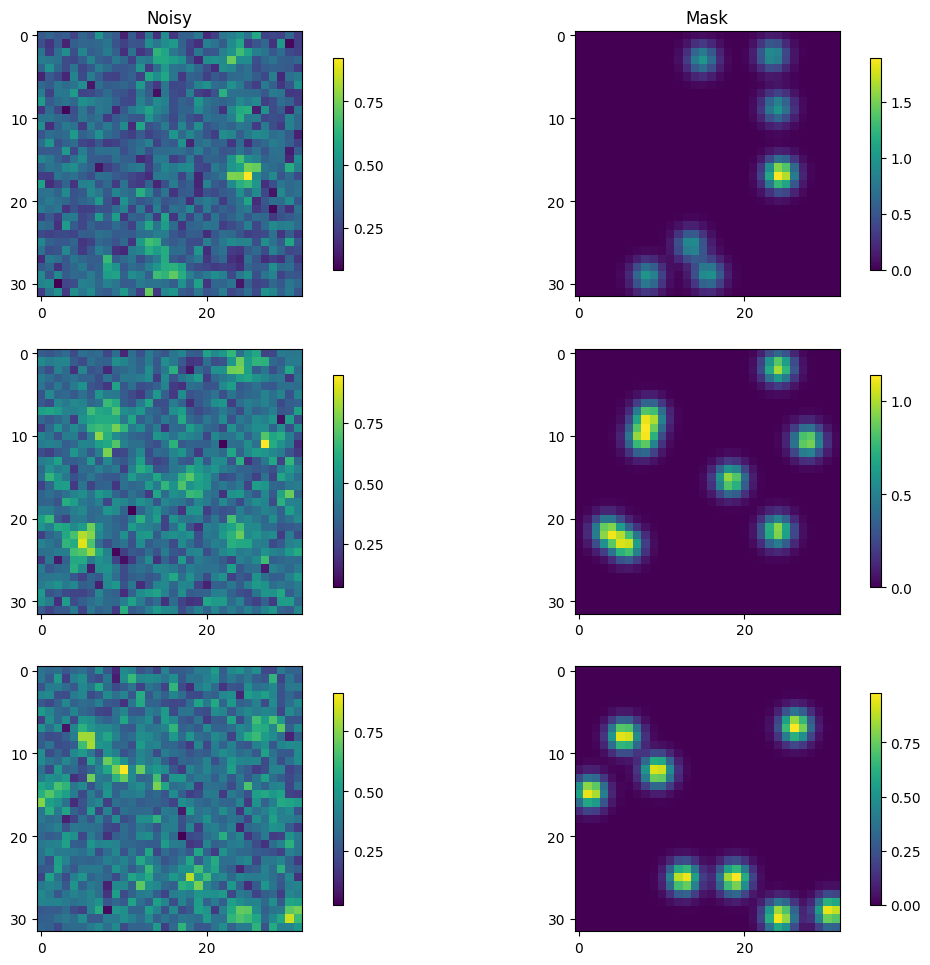

In [6]:
if showNoisyData == True:
    for batch in train_loader:
        noisy, mask = batch
                
        plt.figure(figsize=(12,10))
        plt.subplot(321)
        plt.imshow(noisy[0,0,:,:]); plt.colorbar(shrink=0.8); plt.title('Noisy'); 
        plt.subplot(322);
        plt.imshow(mask[0,0,:,:]); plt.colorbar(shrink=0.8); plt.title('Mask'); 
        plt.subplot(323)
        plt.imshow(noisy[1,0,:,:]); plt.colorbar(shrink=0.8)
        plt.subplot(324);
        plt.imshow(mask[1,0,:,:]); plt.colorbar(shrink=0.8) 
        plt.subplot(325)
        plt.imshow(noisy[2,0,:,:]); plt.colorbar(shrink=0.8)
        plt.subplot(326);
        plt.imshow(mask[2,0,:,:]); plt.colorbar(shrink=0.8) 

        break
        
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()
    plt.show()

## Create and train MSDNet

Lots of options to customize. See dlsia/core/networks/msdnet.py 

In [7]:
in_channels = 1
out_channels = 1
num_layers = 40  
max_dilation = 8  
activation = nn.ReLU()
normalization = nn.BatchNorm2d

msdnet_model = msdnet.MixedScaleDenseNetwork(in_channels = in_channels,
                                             out_channels = out_channels, 
                                             num_layers=num_layers, 
                                             max_dilation = max_dilation, 
                                             activation=activation,
                                             normalization=normalization,
                                            )

pytorch_total_params = sum(p.numel() for p in msdnet_model.parameters() if p.requires_grad)
print("Total number of refineable parameters: ", pytorch_total_params)

Total number of refineable parameters:  9182


### Train the model

We perform the following:

- specify number of epochs,
- select the L2 MSE loss as our scroing criteria,
- select a learning rate of 1/1000
- choose the popular Adam optimizer for traversing the loss terrain

In [8]:
epochs = 100   # set number of epochs
criterion = nn.MSELoss()
learning_rate = 1e-2

optimizer = optim.Adam(msdnet_model.parameters(), lr=learning_rate)

In [9]:
device = helpers.get_device()
msdnet_model.to(device)
msdnet_model, results = train_regression(msdnet_model,
                                         train_loader,   
                                         validation_loader, 
                                         epochs, 
                                         criterion, 
                                         optimizer, 
                                         device=device, 
                                         show=10
                                        ) 
torch.cuda.empty_cache()

Epoch 10 of 100 | Learning rate 1.000e-02
Training Loss: 1.4809e-02 | Validation Loss: 1.3831e-02
Training CC: 0.7768   Validation CC  : 0.7867 
Epoch 20 of 100 | Learning rate 1.000e-02
Training Loss: 9.7021e-03 | Validation Loss: 9.5265e-03
Training CC: 0.8596   Validation CC  : 0.8586 
Epoch 30 of 100 | Learning rate 1.000e-02
Training Loss: 7.7474e-03 | Validation Loss: 7.7937e-03
Training CC: 0.8896   Validation CC  : 0.8858 
Epoch 40 of 100 | Learning rate 1.000e-02
Training Loss: 6.5307e-03 | Validation Loss: 6.7564e-03
Training CC: 0.9079   Validation CC  : 0.9023 
Epoch 50 of 100 | Learning rate 1.000e-02
Training Loss: 5.7035e-03 | Validation Loss: 6.0031e-03
Training CC: 0.9201   Validation CC  : 0.9132 
Epoch 60 of 100 | Learning rate 1.000e-02
Training Loss: 5.0944e-03 | Validation Loss: 5.5280e-03
Training CC: 0.9291   Validation CC  : 0.9203 
Epoch 70 of 100 | Learning rate 1.000e-02
Training Loss: 4.5956e-03 | Validation Loss: 5.1783e-03
Training CC: 0.9362   Validation

In [10]:
plots.plot_training_results_regression(results)

## Create and train SMSNets

Sparse versions of MSDNets with randomly connected layers and dilations are created here

### Specify hyperparameters

Next, the hyperparameters below govern the random network connectivity. Choices include: 

- alpha : modifies distribution of consecutive connection length between network layers/nodes,
- gamma : modifies distribution of of layer/node degree,
- IL : probability of connection between Input node and Layer node, 
- IO : probability of connection between Input node and Output node,
- LO : probability of connection between Layer node and Output node,
- dilation_choices :  set of possible dilations along each individual node connection


The specific parameters and what they do are described in detail in the documentation. Please follow minor  minor comments below for a more cursory explanation.

In [11]:
in_channels = 1 # RGB input image
out_channels = 1 # binary output
num_layers = 40

# When alpha > 0, short-range skip connections are favoured
alpha = 0.20 

# When gamma is 0, the degree of each node is chosen uniformly between 0 and max_k
# specifically, P(degree) \propto degree^-gamma
gamma = 0.0

# we can limit the maximum and minimum degree of our graph 
max_k = 6
min_k = 3

# features channel posibilities per edge
hidden_out_channels = [1] 

# possible dilation choices
dilation_choices = [1,2,3,4,5] 

# Here are some parameters that define how networks are drawn at random
# the layer probabilities dictionairy define connections
layer_probabilities={'LL_alpha':alpha,
                     'LL_gamma': gamma,
                     'LL_max_degree':max_k,
                     'LL_min_degree':min_k,
                     'IL': 0.25,
                     'LO': 0.25,
                     'IO': False}

# if desired, one can introduce scale changes (down and upsample)
# a not-so-thorough look indicates that this isn't really super beneficial
# in the model systems we looked at
sizing_settings = {'stride_base':2, #better keep this at 2
                   'min_power': 0,
                   'max_power': 0}

# defines the type of network we want to build

network_type = "Regression"

### Build networks and train

We specify the number of random networks to initialize and the number of epochs for each is trained.

Network 1


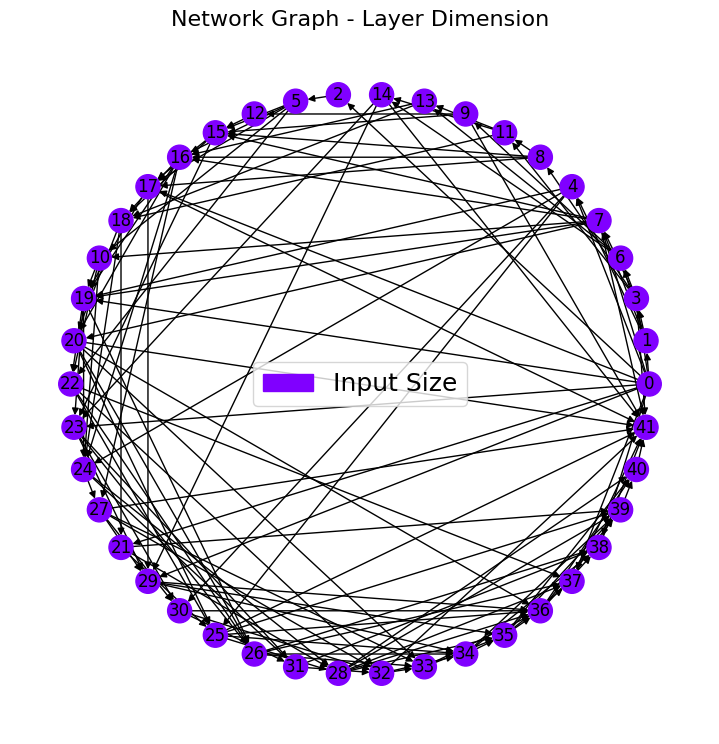

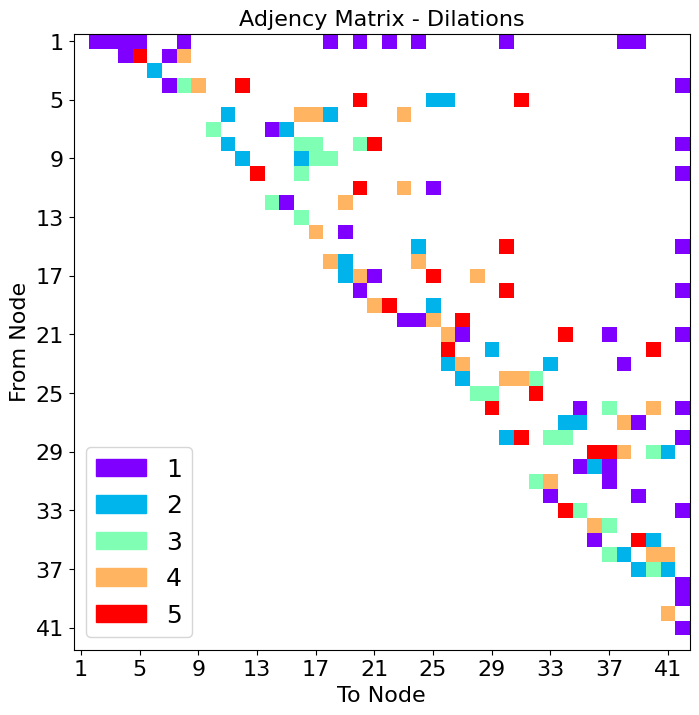

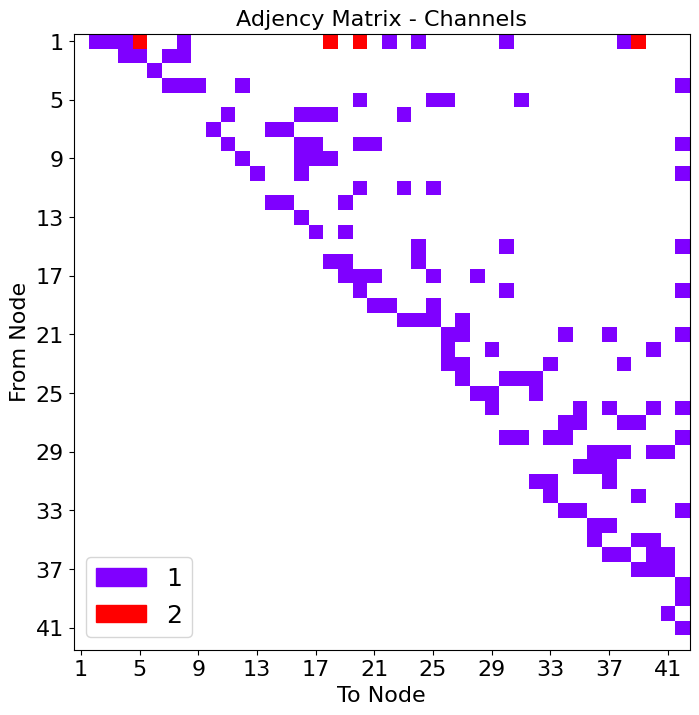

Start training
Total number of refineable parameters:  3844
Epoch 10 of 50 | Learning rate 1.000e-02
Training Loss: 1.5999e-02 | Validation Loss: 1.5701e-02
Training CC: 0.7954   Validation CC  : 0.7952 
Epoch 20 of 50 | Learning rate 1.000e-02
Training Loss: 7.7034e-03 | Validation Loss: 8.6061e-03
Training CC: 0.8923   Validation CC  : 0.8791 
Epoch 30 of 50 | Learning rate 1.000e-02
Training Loss: 5.5668e-03 | Validation Loss: 6.6951e-03
Training CC: 0.9221   Validation CC  : 0.9052 
Epoch 40 of 50 | Learning rate 1.000e-02
Training Loss: 4.7337e-03 | Validation Loss: 6.3684e-03
Training CC: 0.9341   Validation CC  : 0.9103 
Epoch 50 of 50 | Learning rate 1.000e-02
Training Loss: 4.2990e-03 | Validation Loss: 5.9002e-03
Training CC: 0.9403   Validation CC  : 0.9169 


Network 2


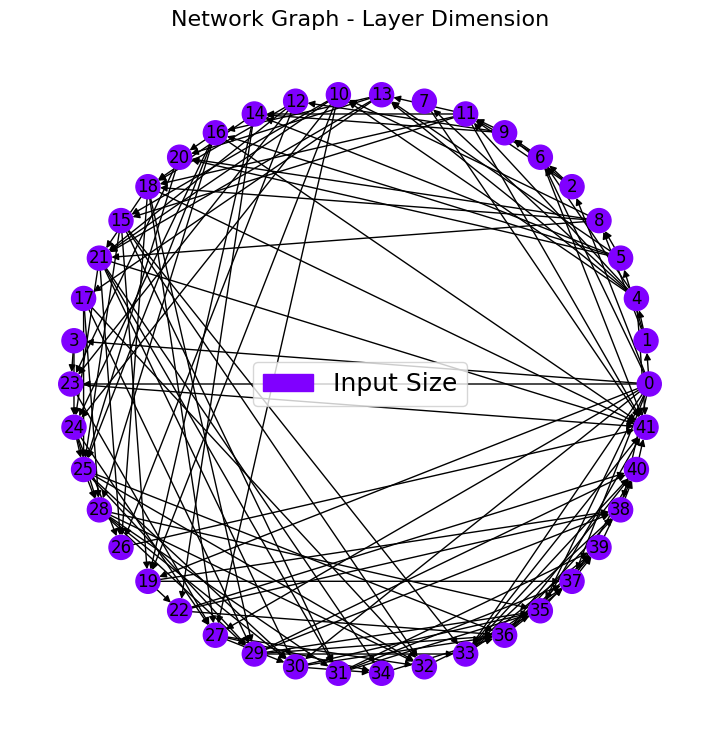

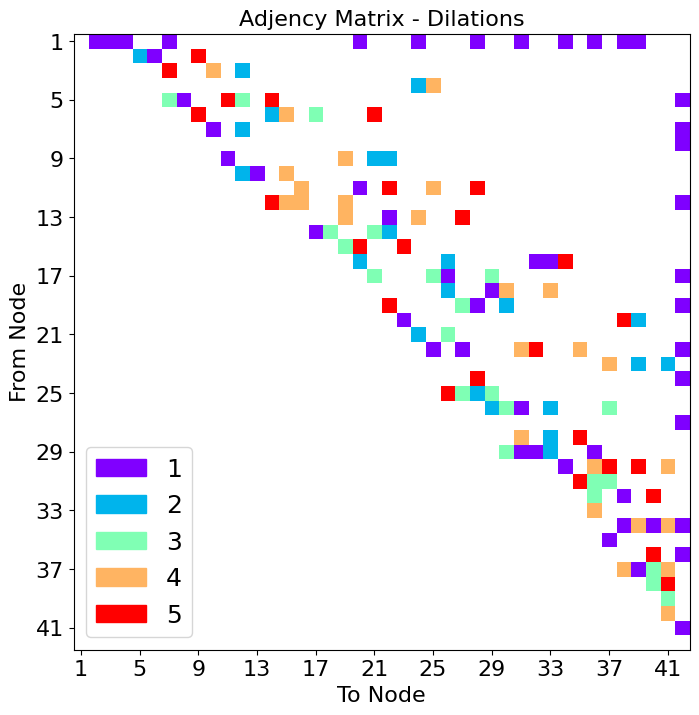

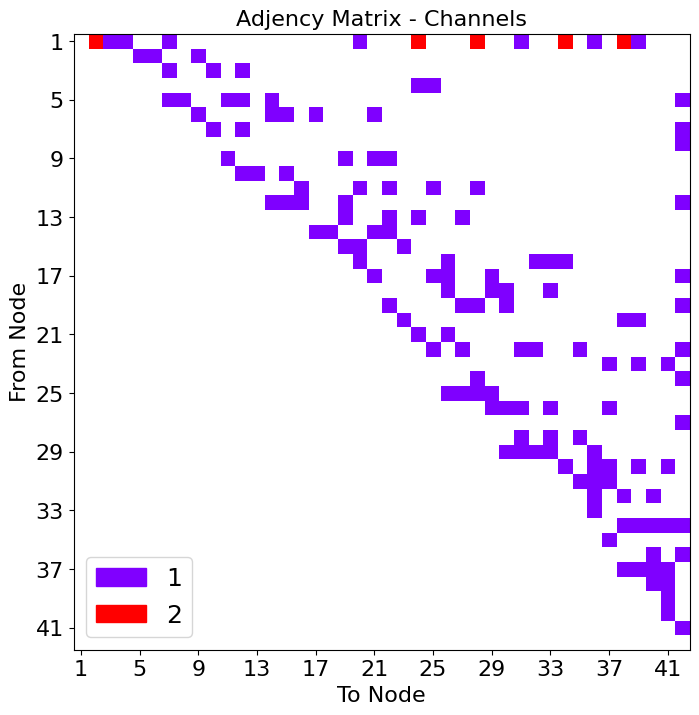

Start training
Total number of refineable parameters:  3877
Epoch 10 of 50 | Learning rate 1.000e-02
Training Loss: 1.0263e-02 | Validation Loss: 8.8870e-03
Training CC: 0.8508   Validation CC  : 0.8686 
Epoch 20 of 50 | Learning rate 1.000e-02
Training Loss: 6.3970e-03 | Validation Loss: 6.2844e-03
Training CC: 0.9100   Validation CC  : 0.9100 
Epoch 30 of 50 | Learning rate 1.000e-02
Training Loss: 4.8886e-03 | Validation Loss: 5.1589e-03
Training CC: 0.9319   Validation CC  : 0.9267 
Epoch 40 of 50 | Learning rate 1.000e-02
Training Loss: 4.2243e-03 | Validation Loss: 4.6693e-03
Training CC: 0.9415   Validation CC  : 0.9335 
Epoch 50 of 50 | Learning rate 1.000e-02
Training Loss: 3.8743e-03 | Validation Loss: 4.4538e-03
Training CC: 0.9464   Validation CC  : 0.9370 


Network 3


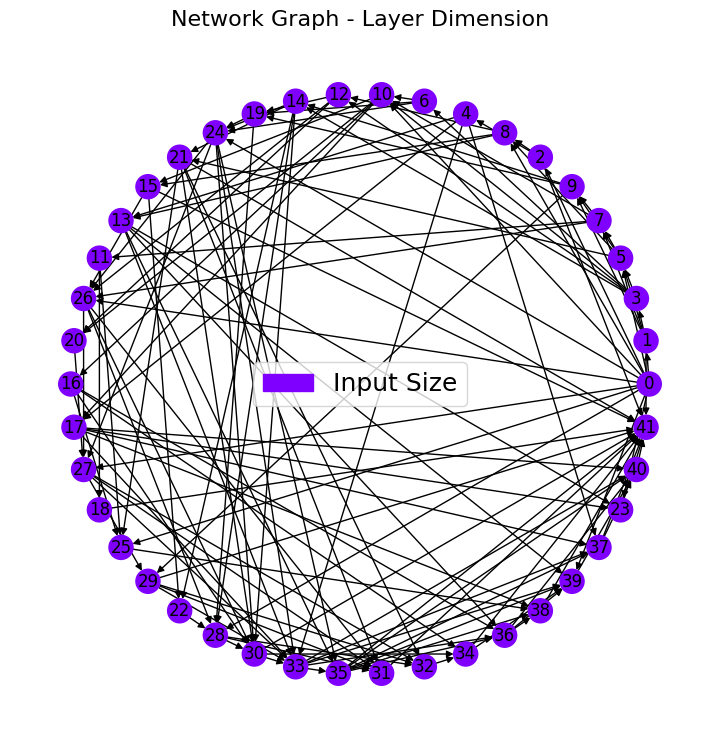

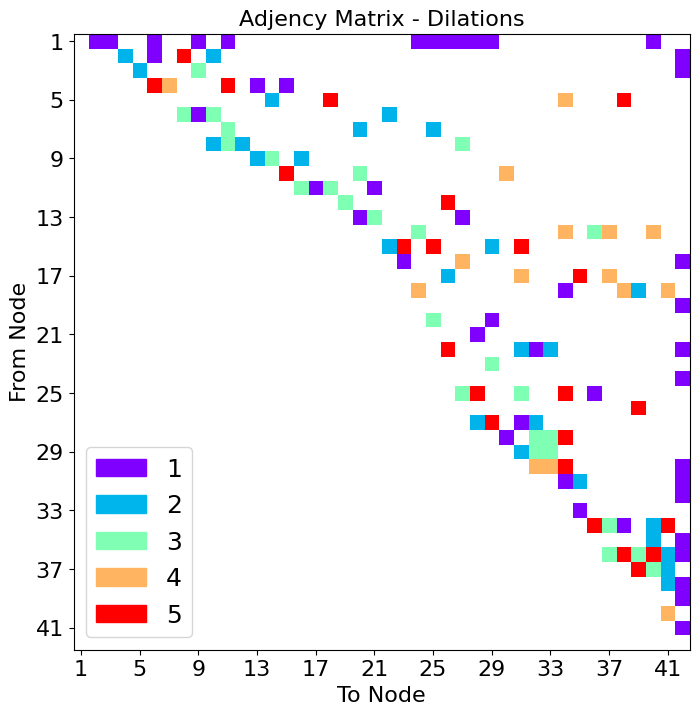

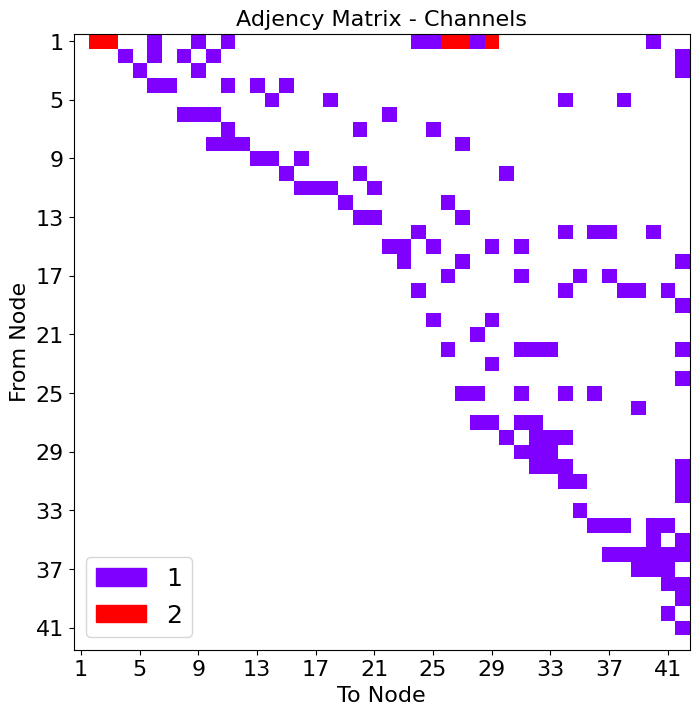

Start training
Total number of refineable parameters:  3302
Epoch 10 of 50 | Learning rate 1.000e-02
Training Loss: 1.0581e-02 | Validation Loss: 1.0207e-02
Training CC: 0.8517   Validation CC  : 0.8503 
Epoch 20 of 50 | Learning rate 1.000e-02
Training Loss: 6.4786e-03 | Validation Loss: 7.3212e-03
Training CC: 0.9094   Validation CC  : 0.8953 
Epoch 30 of 50 | Learning rate 1.000e-02
Training Loss: 5.2044e-03 | Validation Loss: 6.2754e-03
Training CC: 0.9274   Validation CC  : 0.9092 
Epoch 40 of 50 | Learning rate 1.000e-02
Training Loss: 4.4654e-03 | Validation Loss: 5.7581e-03
Training CC: 0.9380   Validation CC  : 0.9176 
Epoch 50 of 50 | Learning rate 1.000e-02
Training Loss: 4.0204e-03 | Validation Loss: 5.3907e-03
Training CC: 0.9443   Validation CC  : 0.9232 


Network 4


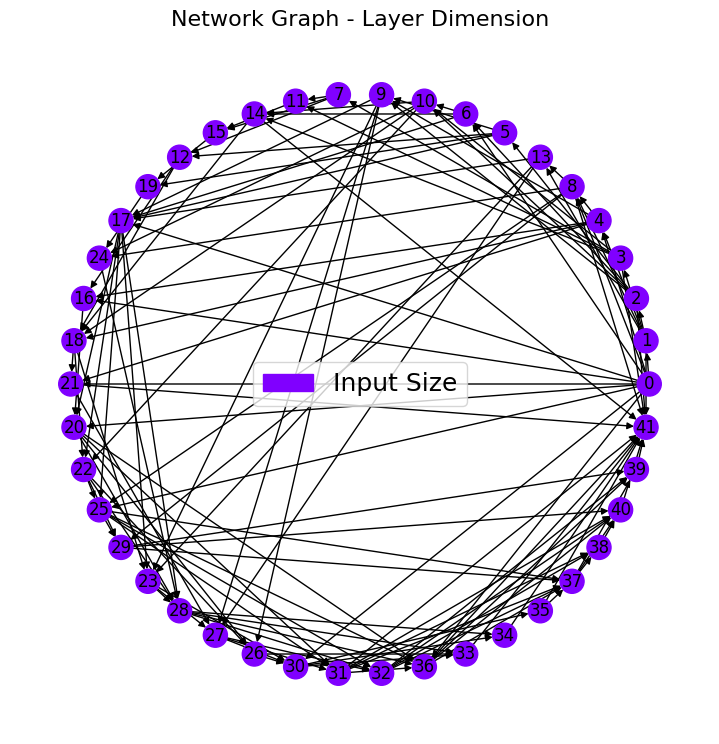

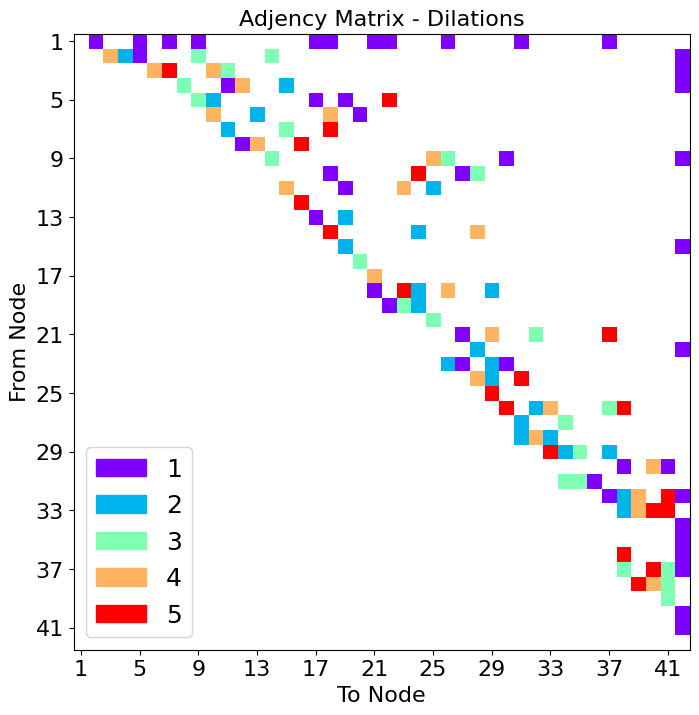

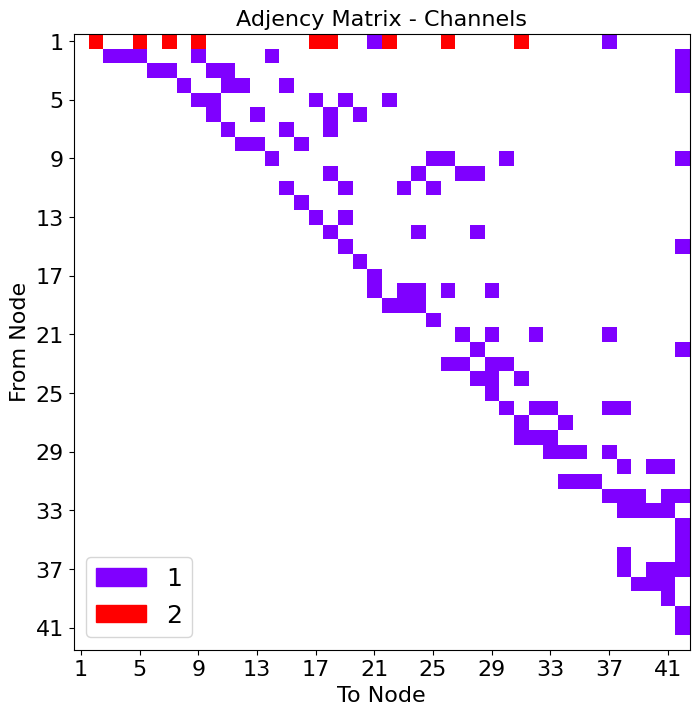

Start training
Total number of refineable parameters:  3499
Epoch 10 of 50 | Learning rate 1.000e-02
Training Loss: 1.0231e-02 | Validation Loss: 9.6956e-03
Training CC: 0.8513   Validation CC  : 0.8562 
Epoch 20 of 50 | Learning rate 1.000e-02
Training Loss: 6.7539e-03 | Validation Loss: 7.1795e-03
Training CC: 0.9045   Validation CC  : 0.8954 
Epoch 30 of 50 | Learning rate 1.000e-02
Training Loss: 5.4177e-03 | Validation Loss: 5.9172e-03
Training CC: 0.9242   Validation CC  : 0.9150 
Epoch 40 of 50 | Learning rate 1.000e-02
Training Loss: 4.7050e-03 | Validation Loss: 5.3960e-03
Training CC: 0.9345   Validation CC  : 0.9231 
Epoch 50 of 50 | Learning rate 1.000e-02
Training Loss: 4.2592e-03 | Validation Loss: 5.2580e-03
Training CC: 0.9410   Validation CC  : 0.9258 


Network 5


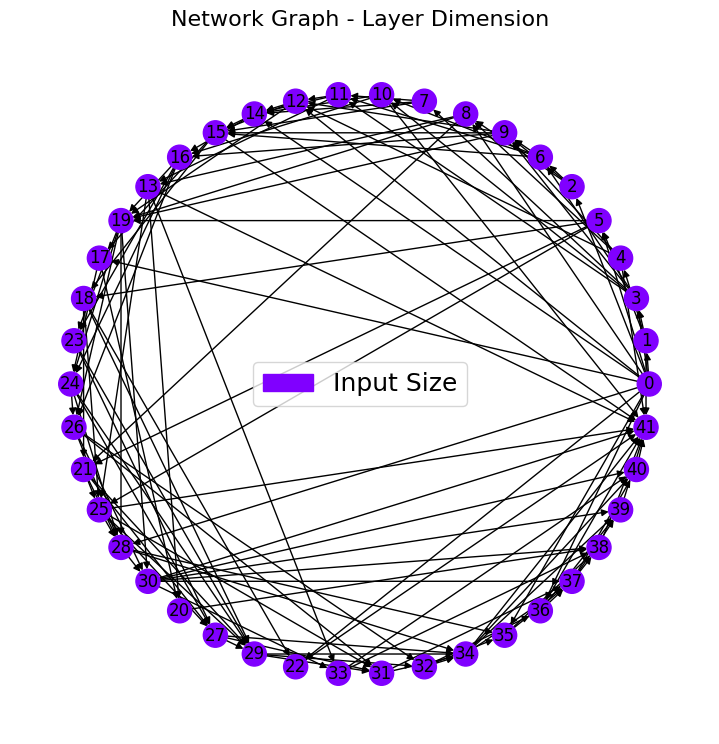

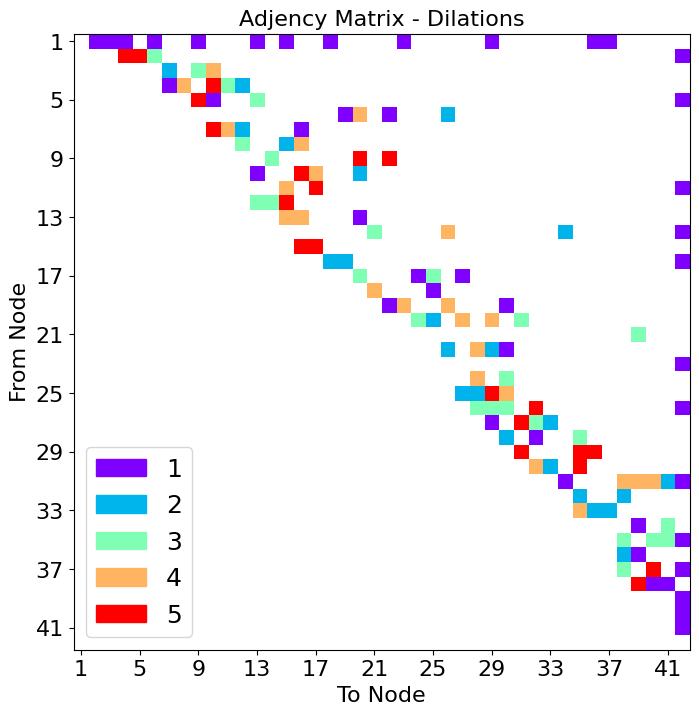

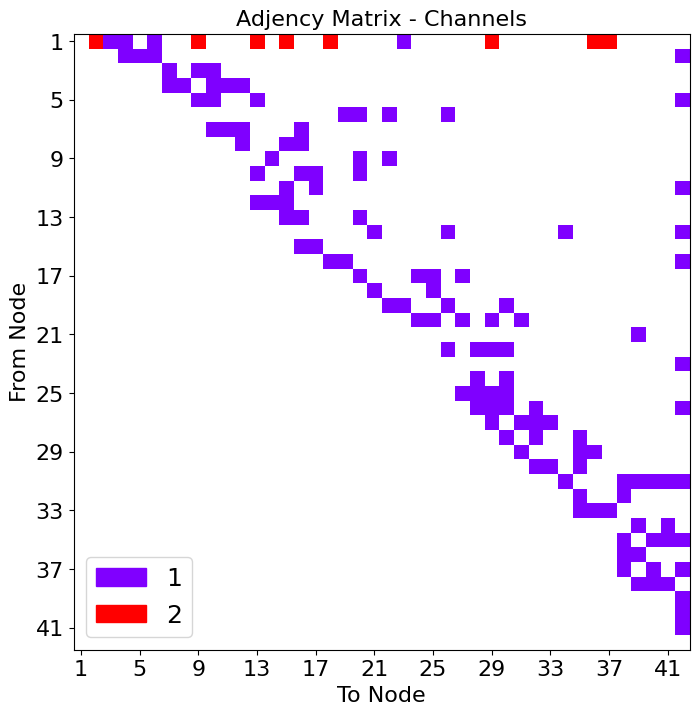

Start training
Total number of refineable parameters:  3670
Epoch 10 of 50 | Learning rate 1.000e-02
Training Loss: 1.3827e-02 | Validation Loss: 1.3171e-02
Training CC: 0.8004   Validation CC  : 0.8179 
Epoch 20 of 50 | Learning rate 1.000e-02
Training Loss: 7.1579e-03 | Validation Loss: 7.7081e-03
Training CC: 0.8991   Validation CC  : 0.8922 
Epoch 30 of 50 | Learning rate 1.000e-02
Training Loss: 5.3919e-03 | Validation Loss: 6.3989e-03
Training CC: 0.9246   Validation CC  : 0.9104 
Epoch 40 of 50 | Learning rate 1.000e-02
Training Loss: 4.6592e-03 | Validation Loss: 5.7732e-03
Training CC: 0.9351   Validation CC  : 0.9198 
Epoch 50 of 50 | Learning rate 1.000e-02
Training Loss: 4.2401e-03 | Validation Loss: 5.4272e-03
Training CC: 0.9412   Validation CC  : 0.9239 


Network 6


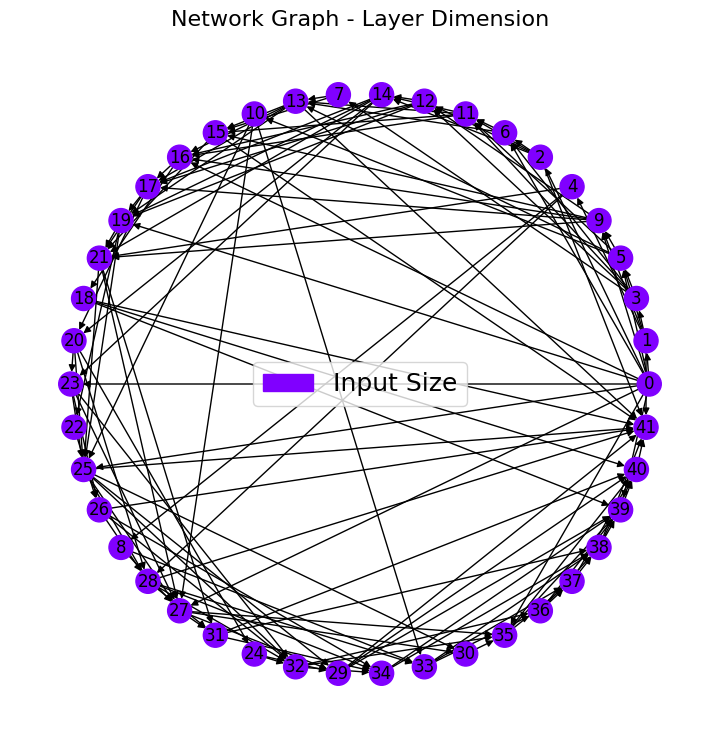

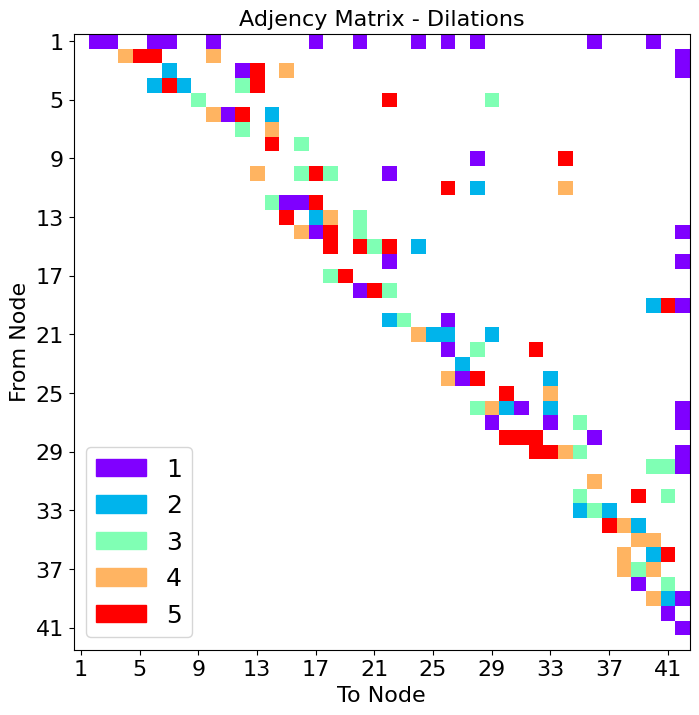

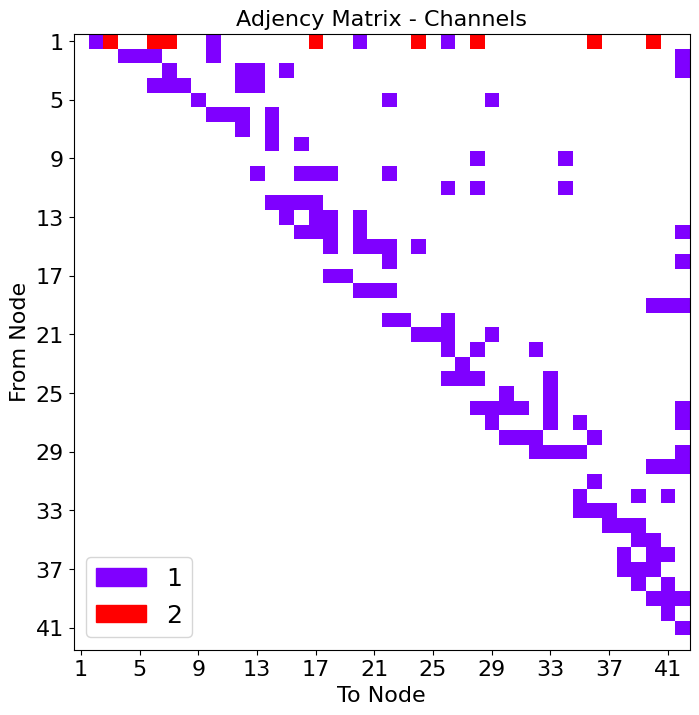

Start training
Total number of refineable parameters:  3950
Epoch 10 of 50 | Learning rate 1.000e-02
Training Loss: 1.7008e-02 | Validation Loss: 1.9044e-02
Training CC: 0.7532   Validation CC  : 0.6985 
Epoch 20 of 50 | Learning rate 1.000e-02
Training Loss: 8.3153e-03 | Validation Loss: 1.4182e-02
Training CC: 0.8814   Validation CC  : 0.7860 
Epoch 30 of 50 | Learning rate 1.000e-02
Training Loss: 6.2014e-03 | Validation Loss: 1.1457e-02
Training CC: 0.9128   Validation CC  : 0.8298 
Epoch 40 of 50 | Learning rate 1.000e-02
Training Loss: 5.5081e-03 | Validation Loss: 9.4422e-03
Training CC: 0.9229   Validation CC  : 0.8619 
Epoch 50 of 50 | Learning rate 1.000e-02
Training Loss: 4.9361e-03 | Validation Loss: 9.0362e-03
Training CC: 0.9312   Validation CC  : 0.8677 


Network 7


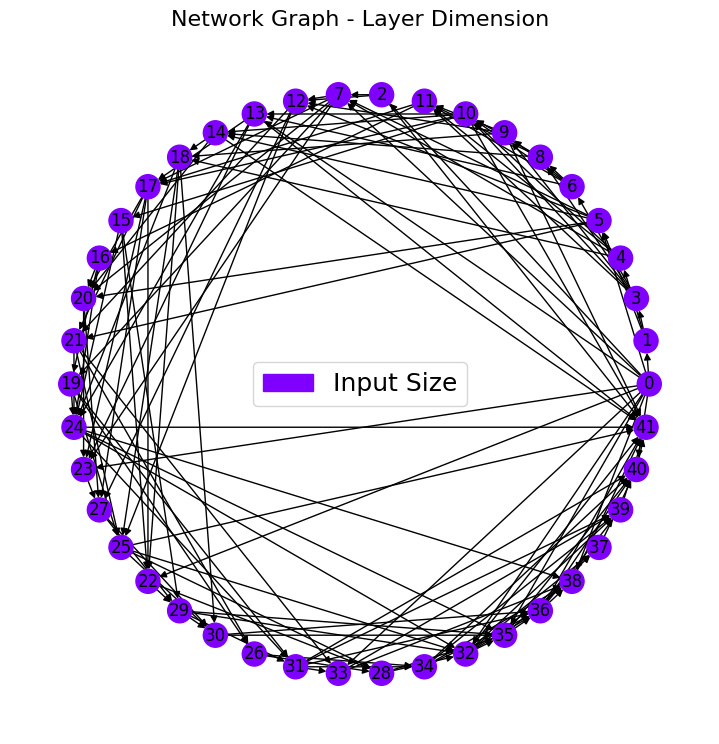

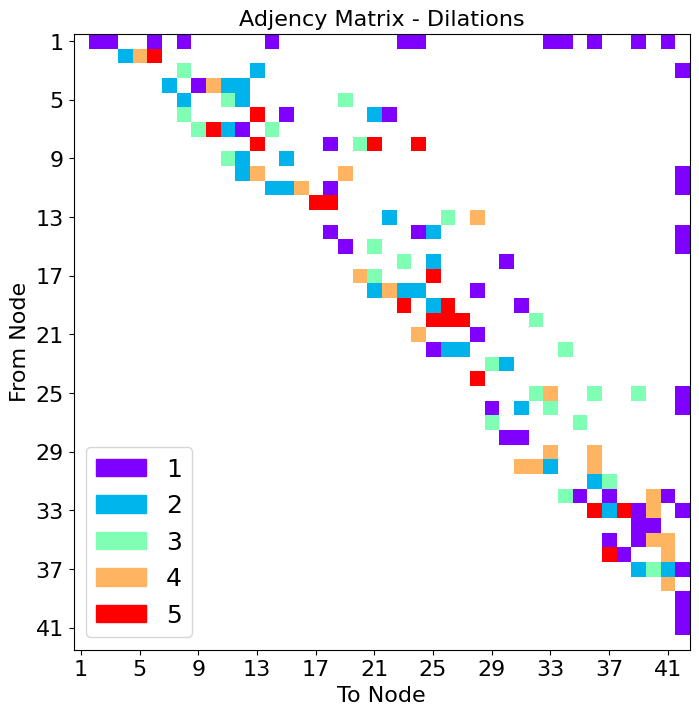

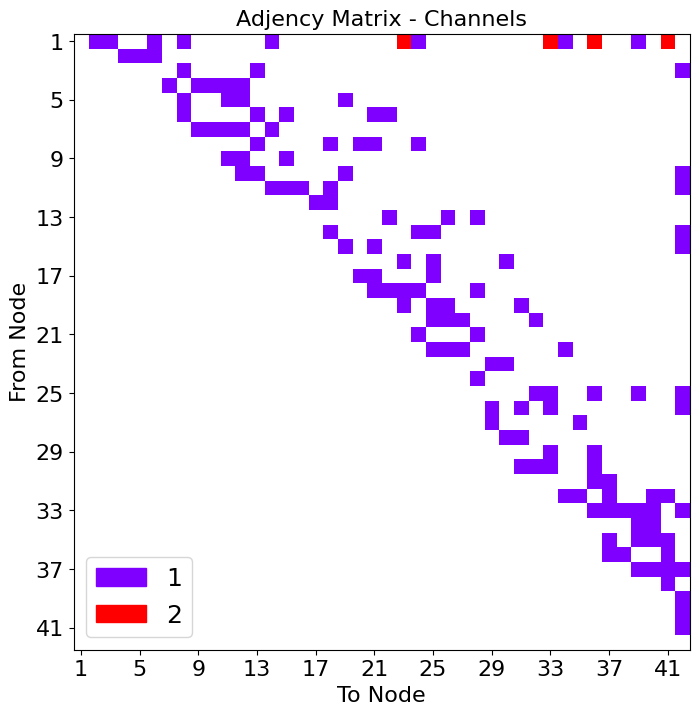

Start training
Total number of refineable parameters:  3750
Epoch 10 of 50 | Learning rate 1.000e-02
Training Loss: 1.1338e-02 | Validation Loss: 1.1778e-02
Training CC: 0.8387   Validation CC  : 0.8265 
Epoch 20 of 50 | Learning rate 1.000e-02
Training Loss: 6.9526e-03 | Validation Loss: 7.7154e-03
Training CC: 0.9027   Validation CC  : 0.8888 
Epoch 30 of 50 | Learning rate 1.000e-02
Training Loss: 5.7851e-03 | Validation Loss: 6.9214e-03
Training CC: 0.9190   Validation CC  : 0.9004 
Epoch 40 of 50 | Learning rate 1.000e-02
Training Loss: 5.1201e-03 | Validation Loss: 6.5576e-03
Training CC: 0.9285   Validation CC  : 0.9051 
Epoch 50 of 50 | Learning rate 1.000e-02
Training Loss: 4.6225e-03 | Validation Loss: 5.9244e-03
Training CC: 0.9358   Validation CC  : 0.9148 


In [12]:
nets = [] 
n_networks = 7
epochs = 50     # Set number of epochs
criterion = nn.MSELoss()   # For segmenting 
learning_rate = 1e-2

for ii in range(n_networks):
    torch.cuda.empty_cache()
    print("Network %i"%(ii+1))
    smsnet_model = smsnet.random_SMS_network(in_channels=in_channels,
                                             out_channels=out_channels,
                                             in_shape=(32,32),
                                             out_shape=(32,32),
                                             sizing_settings=sizing_settings,
                                             layers=num_layers,
                                             dilation_choices=dilation_choices,
                                             hidden_out_channels=hidden_out_channels,
                                             layer_probabilities=layer_probabilities,
                                             network_type=network_type
                                            )
    
    # lets plot the network
    net_plot,dil_plot,chan_plot = draw_sparse_network.draw_network(smsnet_model)
    plt.show()

    nets.append(smsnet_model)
    
    print("Start training")
    pytorch_total_params = sum(p.numel() for p in smsnet_model.parameters() if p.requires_grad)
    print("Total number of refineable parameters: ", pytorch_total_params)

    optimizer = optim.Adam(smsnet_model.parameters(), lr=learning_rate)  # Defined in loop, one per network    
    device = helpers.get_device()
    smsnet_model = smsnet_model.to(device)
    tmp = train_regression(smsnet_model,
                           train_loader,
                           test_loader,
                           epochs,
                           criterion,
                           optimizer,
                           device,
                           show=10)    
    smsnet_model = smsnet_model.cpu()
    plots.plot_training_results_regression(tmp[1]).show()
    

## Testing our models

Finally, we load testing data, pass it through the network, and save results as .png

### Helper functions

In [13]:
def regression_metrics( preds, target):
    """ 
    Here, the Pearson correlation coefficient is calulated between the network 
    predictions and the ground truth.
    """
    tmp = corcoef.cc(preds.cpu().flatten(), target.cpu().flatten() )
    return(tmp)


def segment_imgs(testloader, net, num_display=10, plot=True, std=False):
    """
    This function makes network predictions on testing data found in the 'testloader'
    pytorch dataloader object.
    
    :param testloader: the pyTorch dataloader object used to retrieve testing data
    :param net: the trained deep network
    :param plot: do you want to plot the first 10 network results using matplotlib?
    
    :returns seg_imgs: the predicted images, concatenated into a single tensor
    :returns noisy_imgs: the input images, concatenated into a single tensor
    :returns target_imgs: the ground truth images, concatenated into a single tensor
    """
    torch.cuda.empty_cache()
    
    seg_imgs = []
    noisy_imgs = []
    #target_imgs = []
    
    #running_CC_test_val = 0.0 
    
    counter = 0
    with torch.no_grad():
        for batch in testloader:
            num_display = np.minimum(num_display, len(batch[0]))
            noisy, target = batch

            noisy = torch.FloatTensor(noisy)
            noisy = noisy.to(device)#.unsqueeze(1)

            sigmas = None
            if not std:                
                output = net.to(device)(noisy)
            else:
                output, sigmas = net.to(device)(noisy, 'cpu', True)

            if counter == 0:
                seg_imgs = output.detach().cpu()
                noisy_imgs = noisy.detach().cpu()
                target_imgs = target.detach().cpu()
                if std:
                    sigmas = sigmas.detach().cpu()
            else:
                seg_imgs = torch.cat((seg_imgs, output.detach().cpu()), 0)
                noisy_imgs = torch.cat((noisy_imgs, noisy.detach().cpu()), 0)
                target_imgs = torch.cat((target_imgs, target.detach().cpu()), 0)
                if std:
                    sigmas = sigmas.detach().cpu()


            counter+=1
            
            if plot==True:
                for j in range(5):
                    if not std:
                        print(f'Images for batch # {counter}, number {j}')
                        plt.figure(figsize=(22,5))
                        plt.rcParams.update({'font.size': 20})

                        plt.subplot(131)
                        plt.imshow(noisy.cpu()[j,0,:,:].data); plt.colorbar(shrink=0.8); plt.title('Noisy');             
                        plt.subplot(132)            
                        plt.imshow(output[j,0,:,:].detach().cpu()); plt.colorbar(shrink=0.8); plt.title('Prediction');            
                        plt.subplot(133)            
                        plt.imshow(target.cpu()[j,0,:,:].data); plt.colorbar(shrink=0.8); plt.title('Ground Truth'); 

                        plt.tight_layout()

                        plt.show()
                    else:
                        print(f'Images for batch # {counter}, number {j}')
                        plt.figure(figsize=(22,5))
                        plt.rcParams.update({'font.size': 20})
                        
                        plt.subplot(151)
                        plt.imshow(noisy.cpu()[j,0,:,:].data); 
                        plt.colorbar(shrink=0.8); plt.title('Noisy');             
                        plt.subplot(152)            
                        plt.imshow(output[j,0,:,:].detach().cpu()); 
                        plt.colorbar(shrink=0.8); plt.title('Prediction');            
                        plt.subplot(153)            
                        plt.imshow(sigmas[j,0,:,:].detach().cpu()); 
                        plt.colorbar(shrink=0.8); plt.title('Sigmas');                            
                        plt.subplot(154)            
                        plt.imshow(output[j,0,:,:].detach().cpu() / sigmas[j,0,:,:].detach().cpu(),vmax=30); 
                        plt.colorbar(shrink=0.8); plt.title('Signal to Noise');                            
                        
                        plt.subplot(155)            
                        plt.imshow(target.cpu()[j,0,:,:].data); plt.colorbar(shrink=0.8); plt.title('Ground Truth'); 

                        plt.tight_layout()

                        plt.show()

                        
                
    
    #CC = running_CC_test_val / len(testloader)
    torch.cuda.empty_cache()
    return seg_imgs, noisy_imgs, target_imgs

### MSDNet predictions

Images for batch # 1, number 0


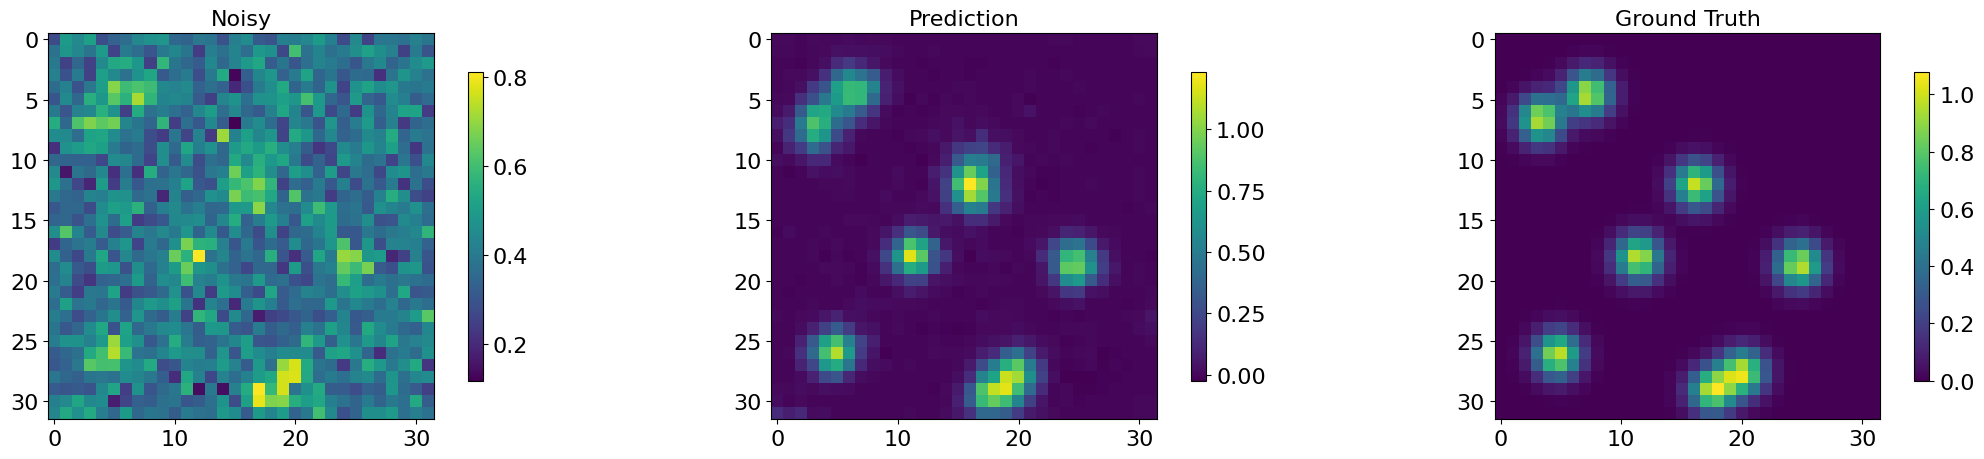

Images for batch # 1, number 1


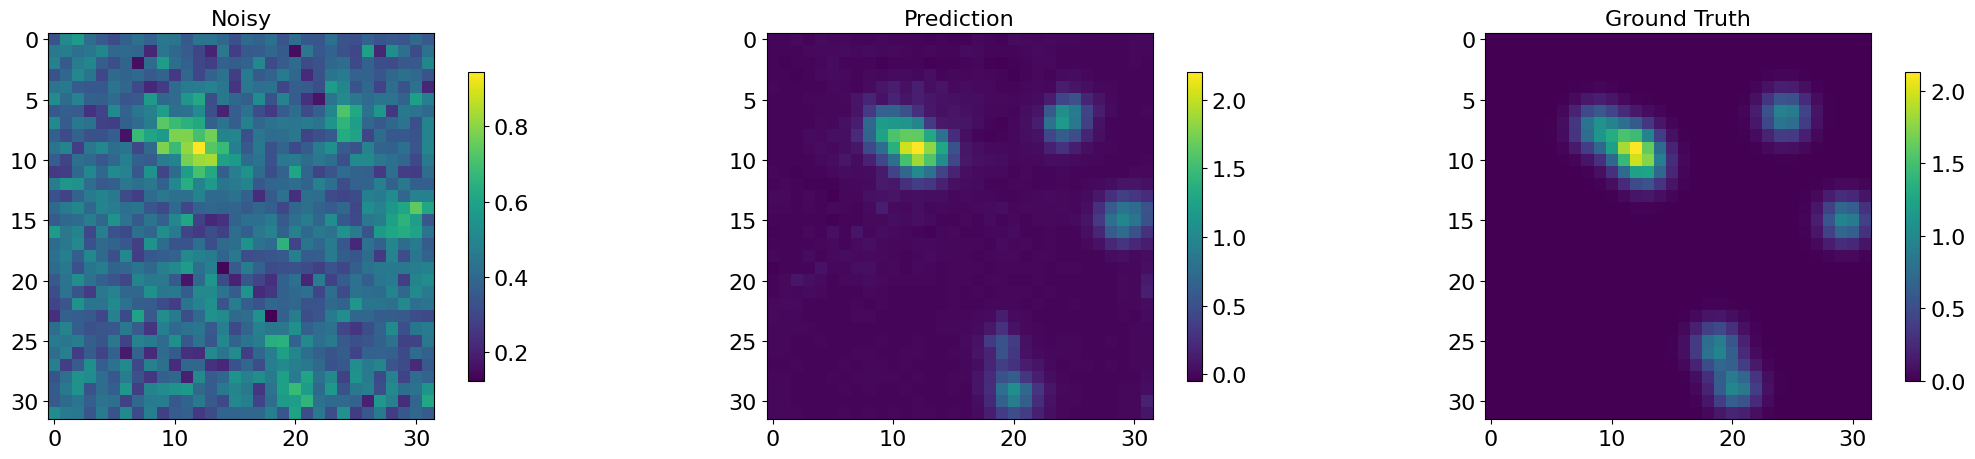

Images for batch # 1, number 2


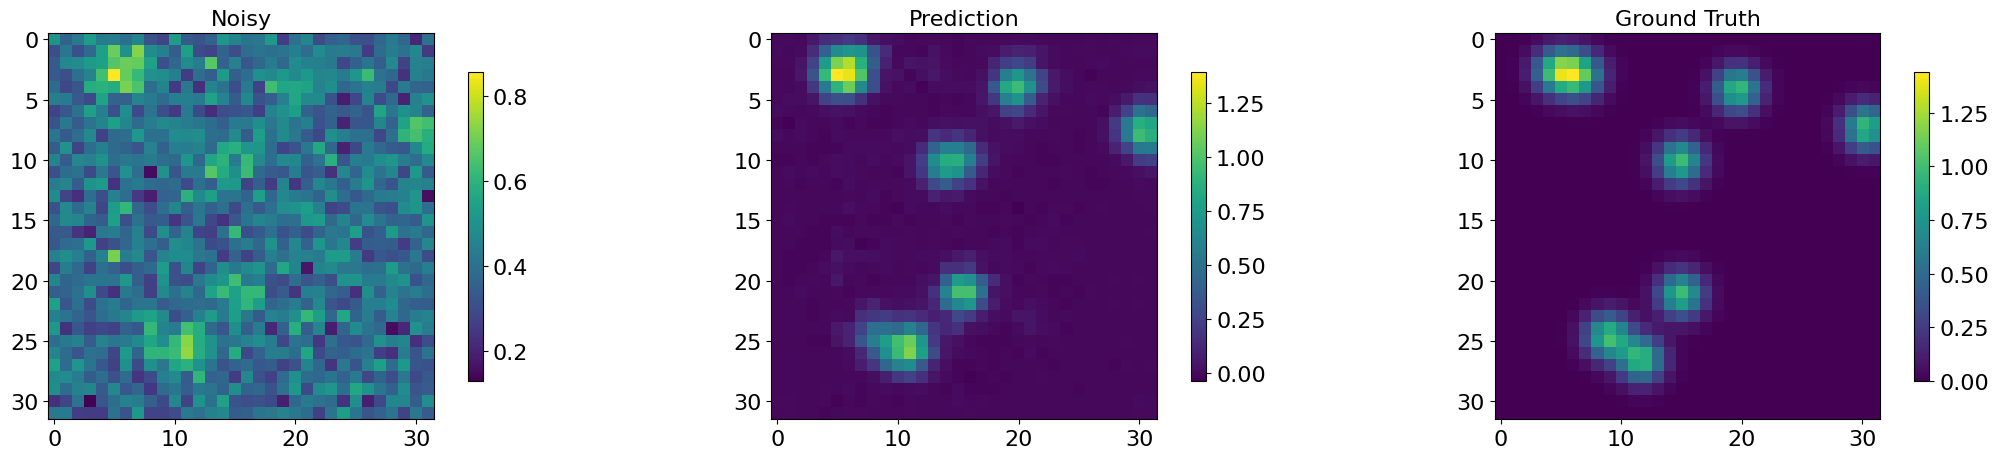

Images for batch # 1, number 3


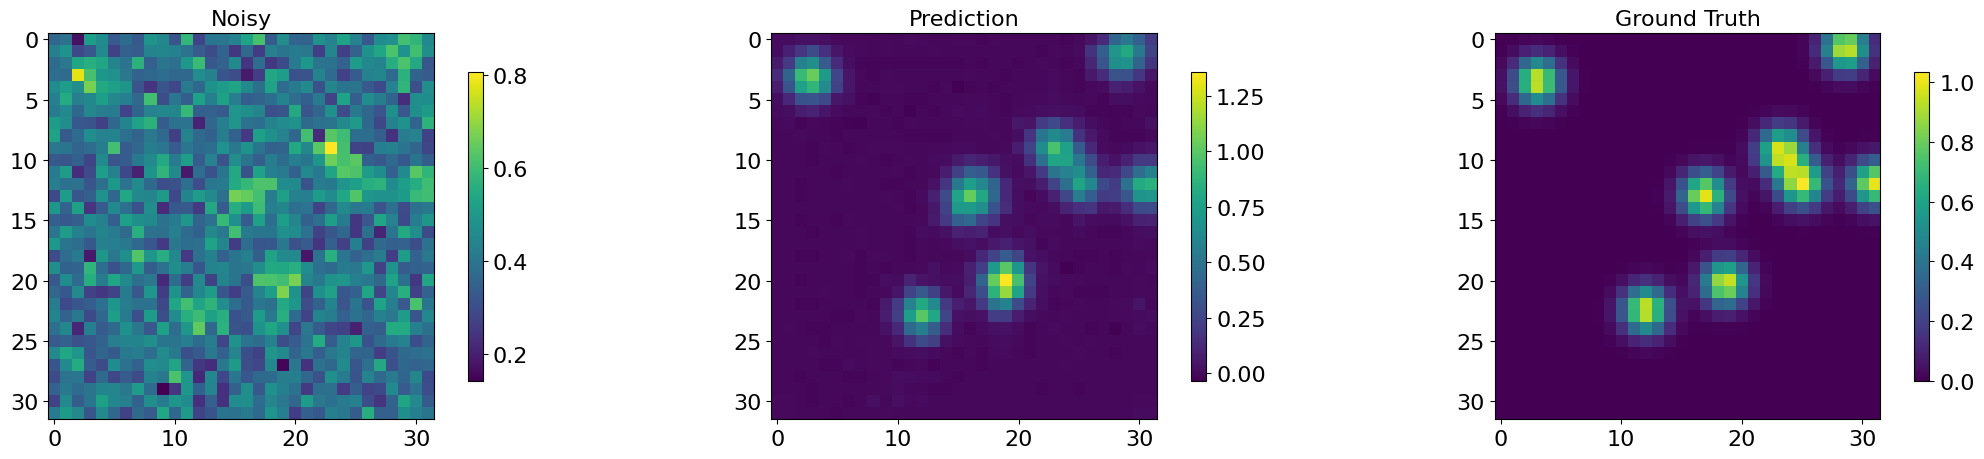

Images for batch # 1, number 4


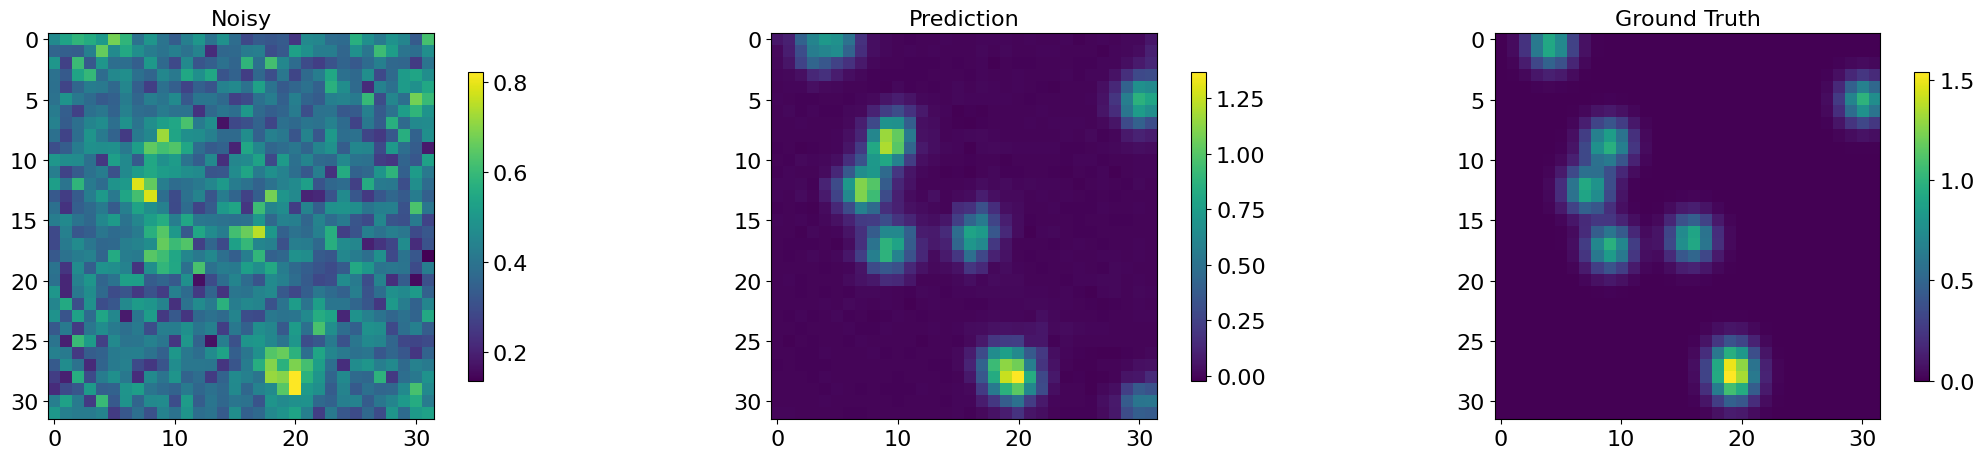

In [15]:
output, noisy, target  = segment_imgs(test_loader, msdnet_model, num_display=3)

### RMSNet predictions

The multiple RMSNets are 'ensembled' together using bagging. Displayed here are:

- Noisy/Prediction: original noisy images and denoised network ensemble predictions,
- Sigmas: standard deviation of denoising predictions
- Signal to Noise: Prediction / Sigmas

In [16]:
bagged_model = baggins.model_baggin(nets,"regression", False)

Images for batch # 1, number 0


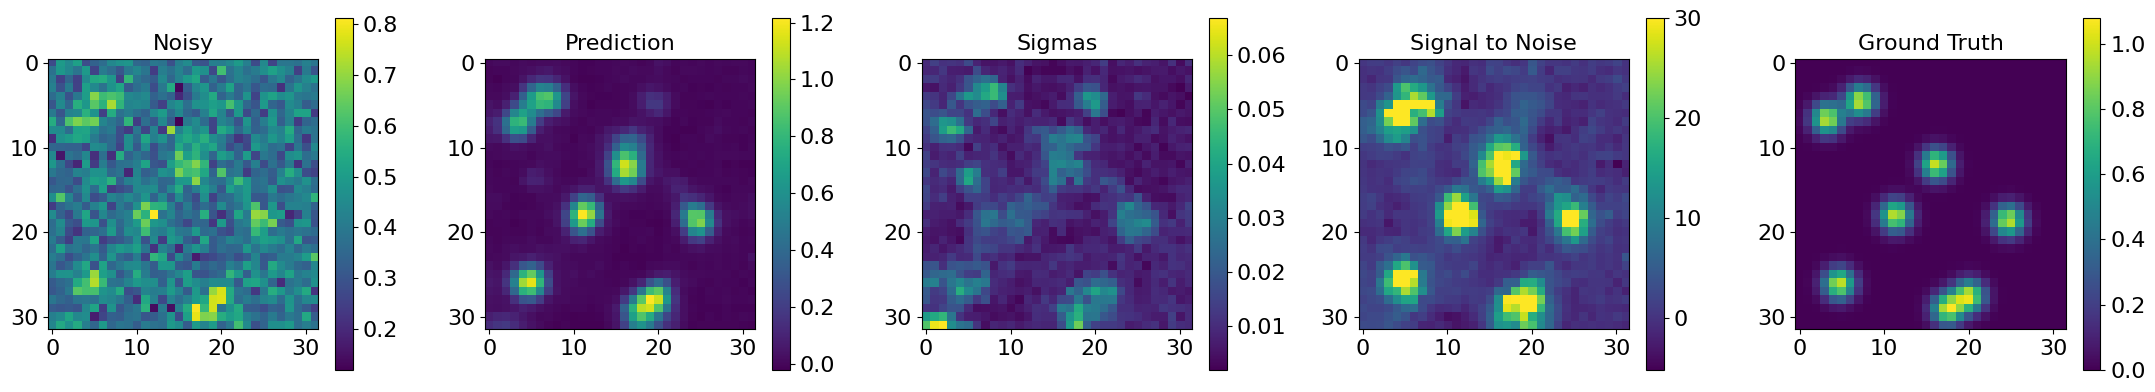

Images for batch # 1, number 1


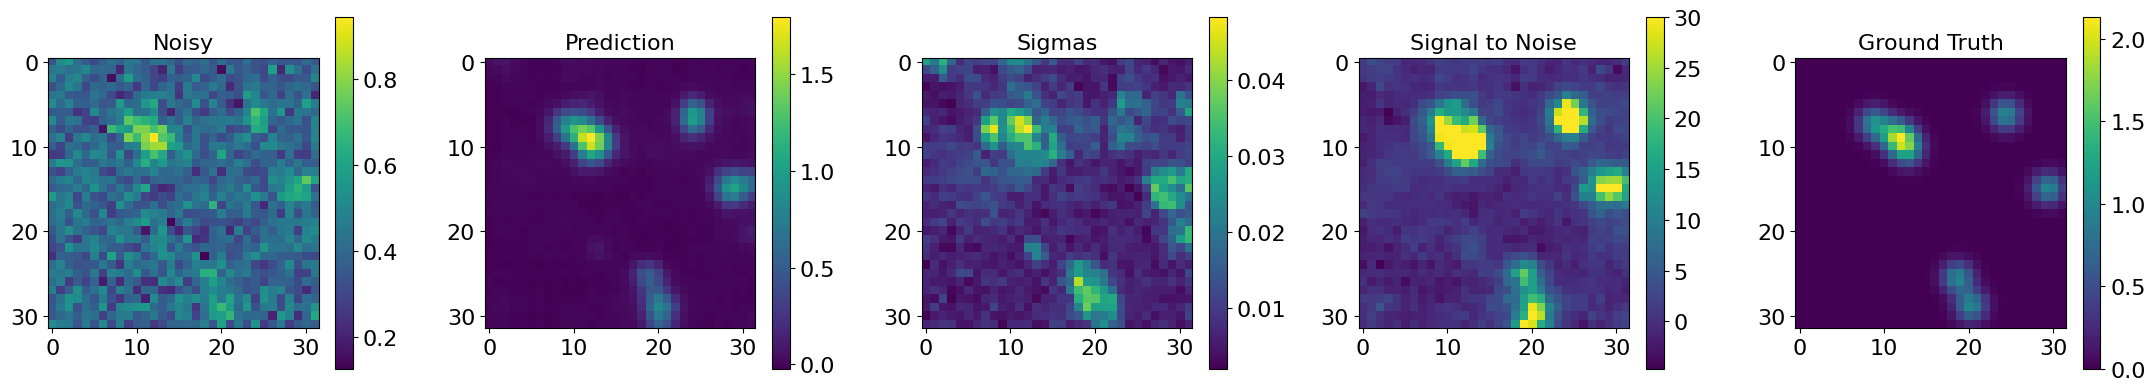

Images for batch # 1, number 2


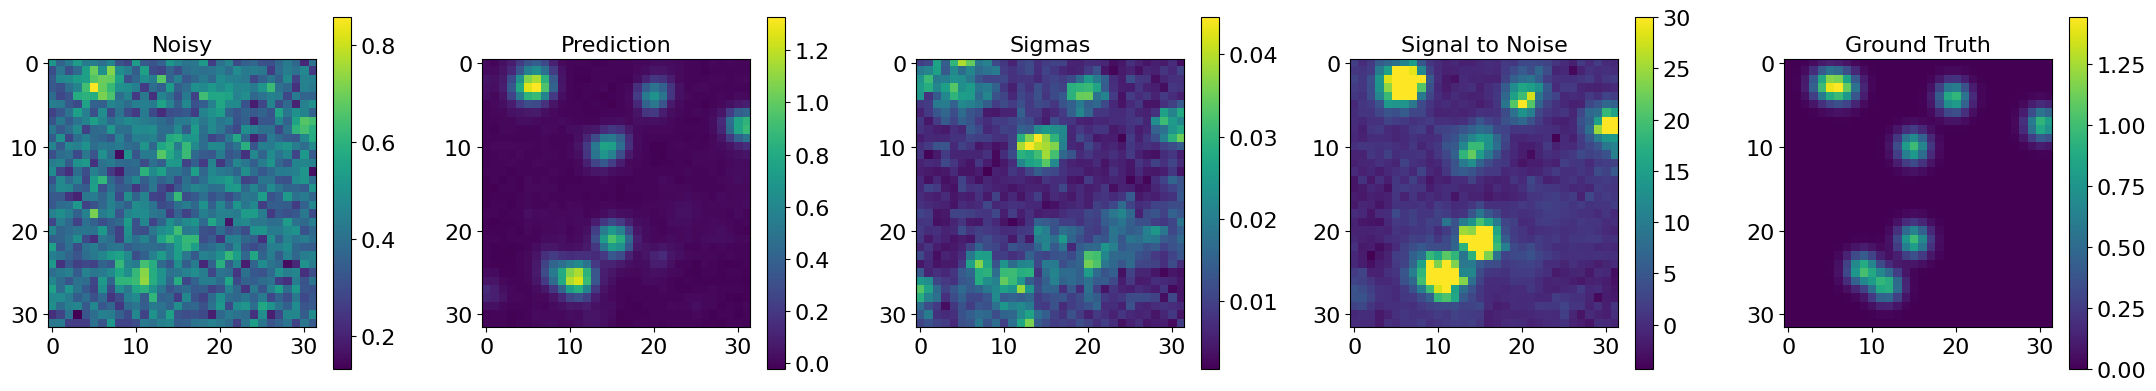

Images for batch # 1, number 3


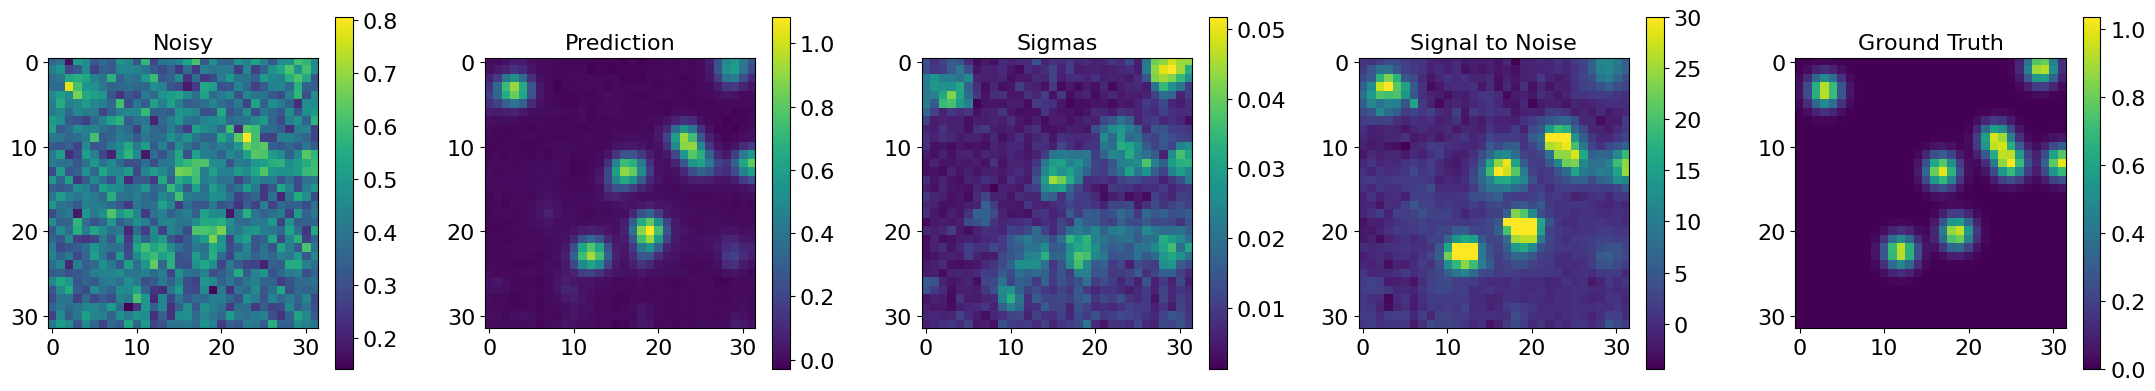

Images for batch # 1, number 4


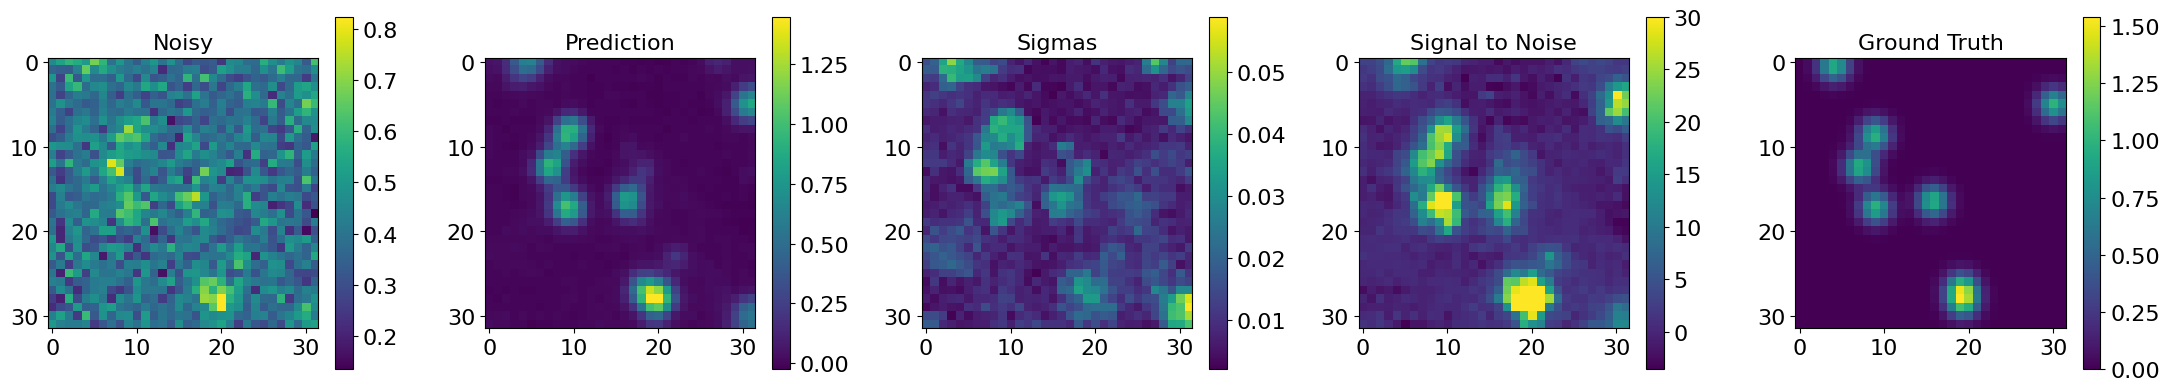

In [17]:
output, noisy, target  = segment_imgs(test_loader, bagged_model, std=True)